---
title: "Support Vector Machine"
format: 
  html:
    embed-resources: true
---

### Load Libraries and Data

We begin by importing and preparing the dataset. The dataset has been preprocessed and includes multiple labels for absenteeism, including binary (high absenteeism or not) and multiclass labels (low, medium, high absenteeism).

In [1]:
from sklearn.metrics import (classification_report, confusion_matrix, \
  accuracy_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Load dataset
full_df = pd.read_csv("../data/clean/absenteeism_model_final.csv")
bss_df = pd.read_csv("../data/clean/absenteeism_model_final_bss.csv")

### SVM Model Class

We define a class SVMModel to streamline the training, evaluation, and optional tuning of support vector machine classifiers.

In [2]:
class SVMModel:
    def __init__(self, data, target_col, C=0.01, kernel='sigmoid', tune=False):
        """
        Initialize the SVMModel with training, validation, and test sets,
        along with feature scaling and default hyperparameters.
        """
        self.target_col = target_col
        self.C = C
        self.kernel = kernel

        # Split features and target
        X = data.drop(columns=[target_col])
        y = data[target_col]

        # Train, validation, and test split (60/20/20)
        X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=42)

        # Standardize features
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(X_train)
        self.X_val_scaled = scaler.transform(X_val)
        self.X_test_scaled = scaler.transform(X_test)

        # Store target splits
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test

        # Train model, evaluate performance, and tune hyperparameters
        self.fit()
        self.evaluate()
        if tune:
            self.tune()

    def fit(self):
        """
        Fit the SVM model using training data and store predictions and probabilities.
        """
        model = SVC(C=self.C, kernel=self.kernel, max_iter=1000, probability=True, random_state=42)
        model.fit(self.X_train_scaled, self.y_train)

        # Store model predictions
        self.y_pred_train = model.predict(self.X_train_scaled)
        self.y_pred_val = model.predict(self.X_val_scaled)
        self.y_pred_test = model.predict(self.X_test_scaled)

        # Store predicted probabilities
        self.y_prob_train = model.predict_proba(self.X_train_scaled)
        self.y_prob_val = model.predict_proba(self.X_val_scaled)
        self.y_prob_test = model.predict_proba(self.X_test_scaled)

    def evaluate(self):
        """
        Print confusion matrix, classification report, and plot ROC curve with AUC.
        """
        print("Confusion Matrix:")
        cm = confusion_matrix(self.y_test, self.y_pred_test)
        print(cm)

        # Plot confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(self.y_test), yticklabels=np.unique(self.y_test))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f"SVM Confusion Matrix for '{self.target_col}'")
        plt.show()

        print("\nClassification Report:")
        print(classification_report(self.y_test, self.y_pred_test))

        # ROC and AUC
        if len(np.unique(self.y_test)) == 2:
            # Binary classification
            y_roc = self.y_test
            y_roc_prob = self.y_prob_test[:, 1]
        else:
            # Multiclass - flatten for ROC
            label_binarizer = LabelBinarizer().fit(self.y_train)
            y_roc = label_binarizer.transform(self.y_test).ravel()
            y_roc_prob = self.y_prob_test.ravel()

        auc = roc_auc_score(y_roc, y_roc_prob)
        print(f"AUC: {auc:.4f}")

        # Plot ROC Curve
        RocCurveDisplay.from_predictions(y_roc, y_roc_prob, plot_chance_level=True)
        plt.title(f"SVM ROC Curve for '{self.target_col}'")
        plt.grid(True)
        plt.show()

    def tune(self):
        """
        Tune the regularization parameter C using a manual grid search,
        and plot training and validation accuracy.
        """
        hp = []
        val_acc = []
        train_acc = []

        # Try different values of C
        candidate_Cs = [1e-5, 1e-4, 5e-4, 0.001, 0.005, 0.01, 0.1, 1, 10]
        for C in candidate_Cs:
            model = SVC(C=C, kernel=self.kernel, max_iter=1000)
            model.fit(self.X_train_scaled, self.y_train)

            # Predict and store accuracy
            y_p_train = model.predict(self.X_train_scaled)
            y_p_val = model.predict(self.X_val_scaled)

            train_acc.append(accuracy_score(self.y_train, y_p_train))
            val_acc.append(accuracy_score(self.y_val, y_p_val))
            hp.append(C)

        # Plot hyperparameter tuning results
        fig, ax = plt.subplots()
        ax.plot(hp, val_acc, "r-o", label="Validation Accuracy")
        ax.plot(hp, train_acc, "b-o", label="Training Accuracy")
        ax.set(xlabel='C (Regularization Parameter)', ylabel='Accuracy', title='Hyperparameter Tuning')
        ax.set_xscale('log')
        ax.legend()
        ax.grid(True)
        plt.show()

In [3]:
# def fit_svm_model(data, target_col, C=0.1, kernel='sigmoid'):
#   X = data.drop(columns=[target_col])
#   y = data[target_col]

#   # Train-test split
#   X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#   X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)
  
#   # Standardize features
#   scaler = StandardScaler()
#   X_train_scaled = scaler.fit_transform(X_train)
#   X_val_scaled = scaler.fit_transform(X_val)
#   X_test_scaled = scaler.transform(X_test)

#   # Fit SVM with kernel
#   model = SVC(C=C, kernel=kernel, max_iter=1000, probability=True, random_state=42)
#   model.fit(X_train_scaled, y_train)

#   # Predict classes
#   y_pred_train = model.predict(X_train_scaled)
#   y_pred_val = model.predict(X_val_scaled)
#   y_pred_test = model.predict(X_test_scaled)
  
#   # Predict probabilities
#   y_prob_train = model.predict_proba(X_train_scaled)[:, 1]
#   y_prob_val = model.predict_proba(X_val_scaled)[:, 1]
#   y_prob_test = model.predict_proba(X_test_scaled)[:, 1]

#   # Evaluate
#   print("Confusion Matrix:")
#   print(confusion_matrix(y_test, y_pred_test))

#   print("\nClassification Report:")
#   print(classification_report(y_test, y_pred_test))

#   auc = roc_auc_score(y_test, y_prob_test)
#   print(f"AUC: {auc:.4f}")

#   RocCurveDisplay.from_predictions(y_test, y_prob_test, plot_chance_level=True)
#   plt.title(f"SVM ROC Curve for {target_col}")
#   plt.grid(True)
#   plt.show()

### Binary Classification Models
We start by training SVMs on binary target variables representing high absenteeism.

Confusion Matrix:
[[878 626]
 [312 744]]


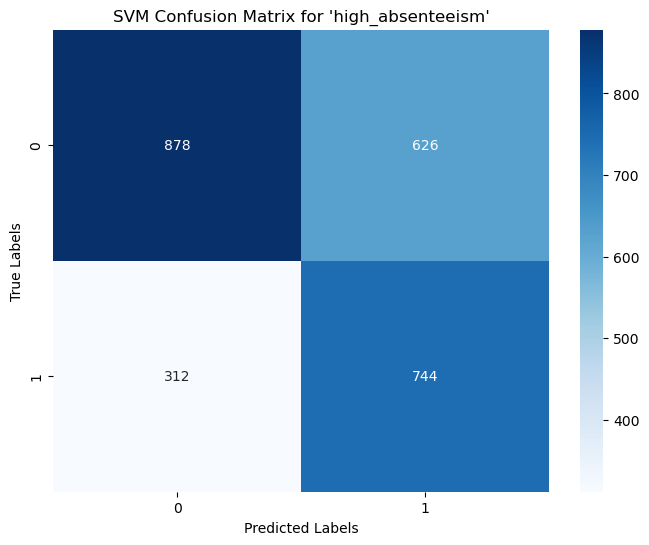


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65      1504
           1       0.54      0.70      0.61      1056

    accuracy                           0.63      2560
   macro avg       0.64      0.64      0.63      2560
weighted avg       0.66      0.63      0.64      2560

AUC: 0.7215


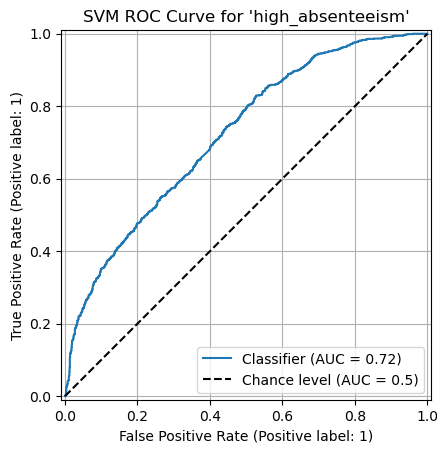

In [4]:
# Model with self-defined absenteeism threshold
df1 = full_df.drop(columns=["absenteeism_class", "high_absenteeism_doe"])
SVMModel(df1, "high_absenteeism");

Confusion Matrix:
[[1137  680]
 [ 268  475]]


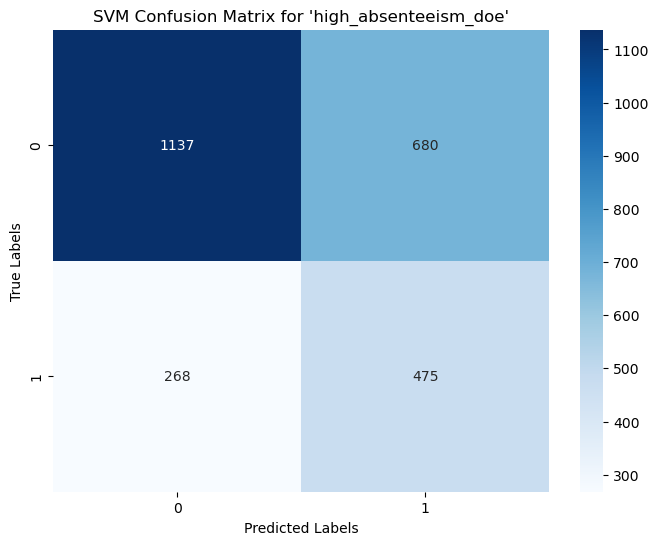


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1817
           1       0.41      0.64      0.50       743

    accuracy                           0.63      2560
   macro avg       0.61      0.63      0.60      2560
weighted avg       0.69      0.63      0.65      2560

AUC: 0.6886


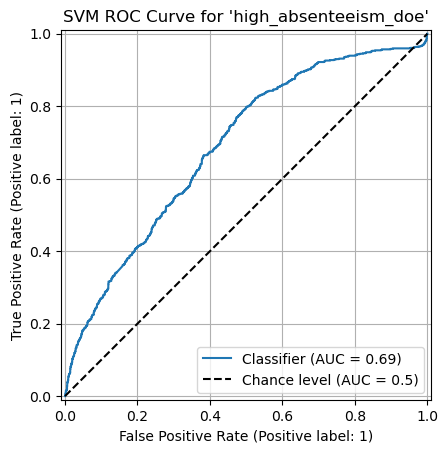

In [5]:
# Model with DOE-defined absenteeism threshold
df2 = full_df.drop(columns=["absenteeism_class", "high_absenteeism"])
SVMModel(df2, "high_absenteeism_doe");

### Kernel Adjustment

While transformations helped improve our logistic models, they didn’t benefit SVM. Instead, we now test different kernel types for performance differences.

Confusion Matrix:
[[ 185 1319]
 [ 233  823]]


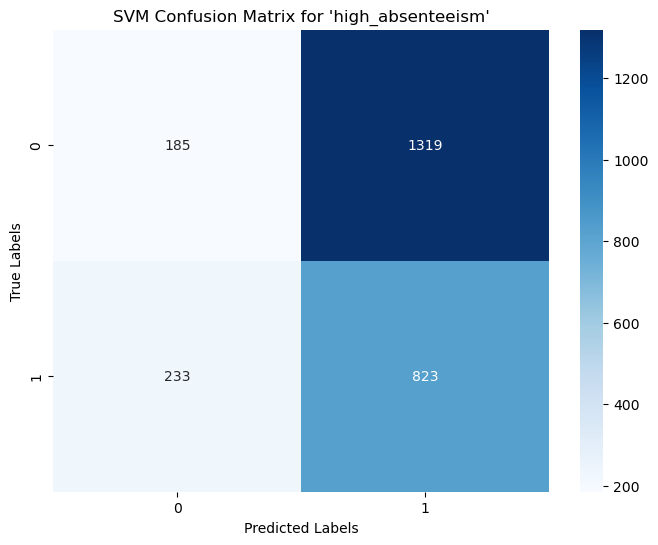


Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.12      0.19      1504
           1       0.38      0.78      0.51      1056

    accuracy                           0.39      2560
   macro avg       0.41      0.45      0.35      2560
weighted avg       0.42      0.39      0.33      2560

AUC: 0.5276


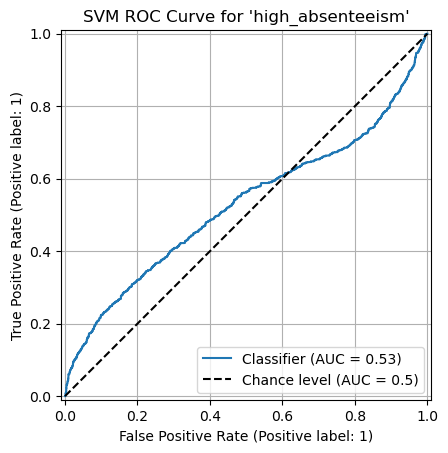

In [6]:
# Model with self-defined absenteeism threshold; using rbf kernel
df3 = full_df.drop(columns=["absenteeism_class", "high_absenteeism_doe"])
SVMModel(df3, "high_absenteeism", kernel="rbf");

Confusion Matrix:
[[   1 1503]
 [   5 1051]]


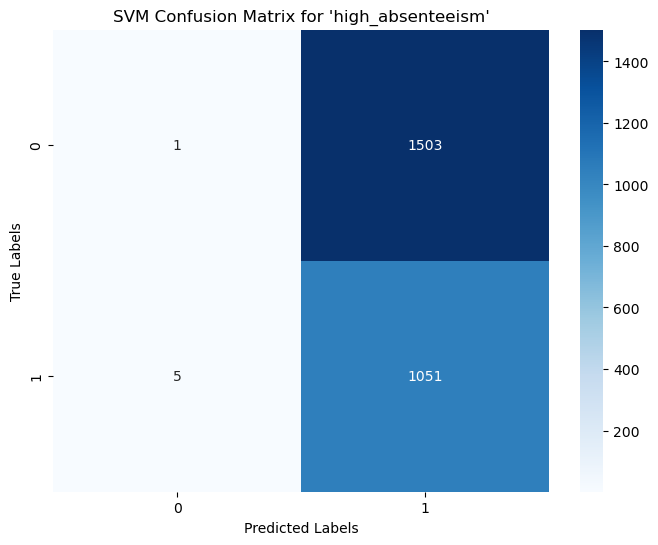


Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.00      0.00      1504
           1       0.41      1.00      0.58      1056

    accuracy                           0.41      2560
   macro avg       0.29      0.50      0.29      2560
weighted avg       0.27      0.41      0.24      2560

AUC: 0.4474


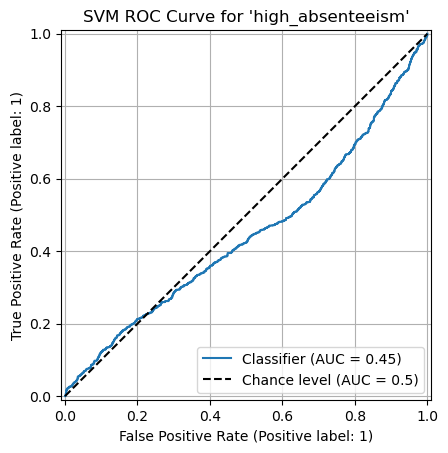

In [7]:
# Model with self-defined absenteeism threshold; using poly kernel
df4 = full_df.drop(columns=["absenteeism_class", "high_absenteeism_doe"])
SVMModel(df4, "high_absenteeism", kernel="poly");

### Multiclass

Next, we model on the multiclass variable `absenteeism_class`, which categorizes observations as low, medium, or high absenteeism. We test different kernels to see if any has an advantage over the others. 

Confusion Matrix:
[[ 26 485 362]
 [  9 297 540]
 [ 17 104 720]]


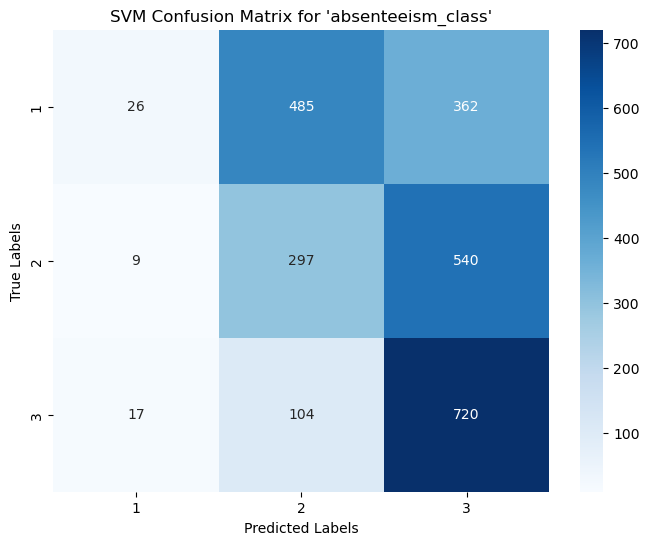


Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.03      0.06       873
           2       0.34      0.35      0.34       846
           3       0.44      0.86      0.58       841

    accuracy                           0.41      2560
   macro avg       0.43      0.41      0.33      2560
weighted avg       0.43      0.41      0.32      2560

AUC: 0.5488


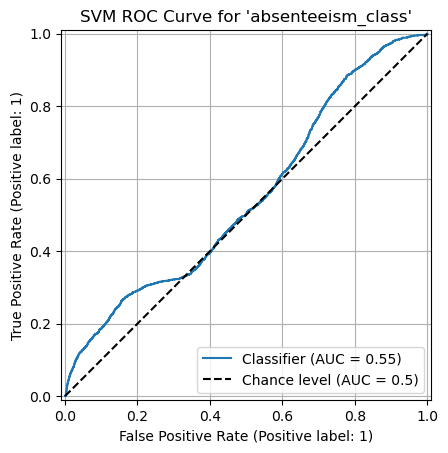

In [8]:
# Model with self absenteeism threshold; using sigmoid kernel
df5 = full_df.drop(columns=["high_absenteeism", "high_absenteeism_doe"])
SVMModel(df5, "absenteeism_class");

Confusion Matrix:
[[ 58   0 815]
 [ 19   0 827]
 [ 13   1 827]]


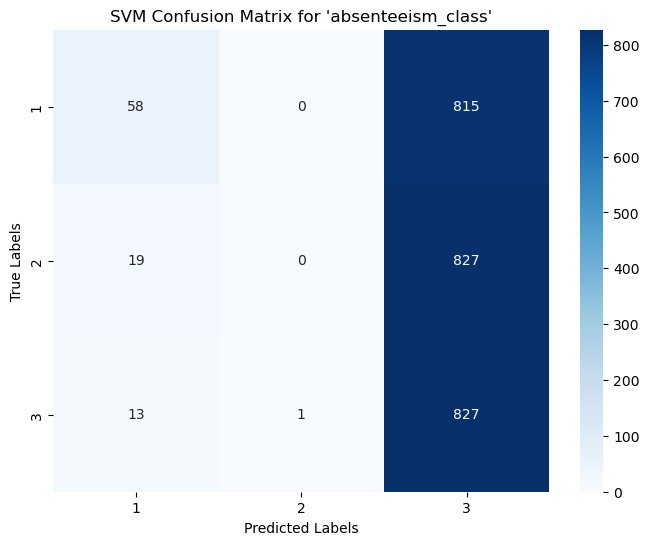


Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.07      0.12       873
           2       0.00      0.00      0.00       846
           3       0.33      0.98      0.50       841

    accuracy                           0.35      2560
   macro avg       0.33      0.35      0.21      2560
weighted avg       0.33      0.35      0.21      2560

AUC: 0.5255


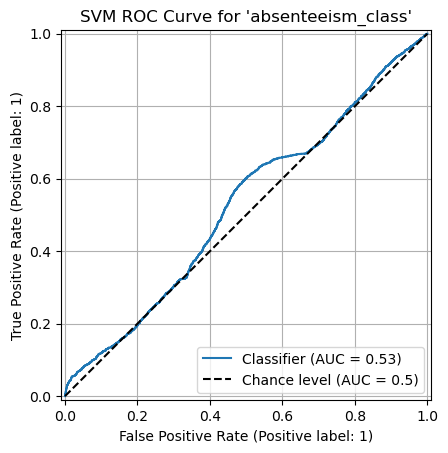

In [9]:
# Model with self absenteeism threshold; using linear kernel
SVMModel(df5, "absenteeism_class", kernel="linear");

Confusion Matrix:
[[235  35 603]
 [105  68 673]
 [151 120 570]]


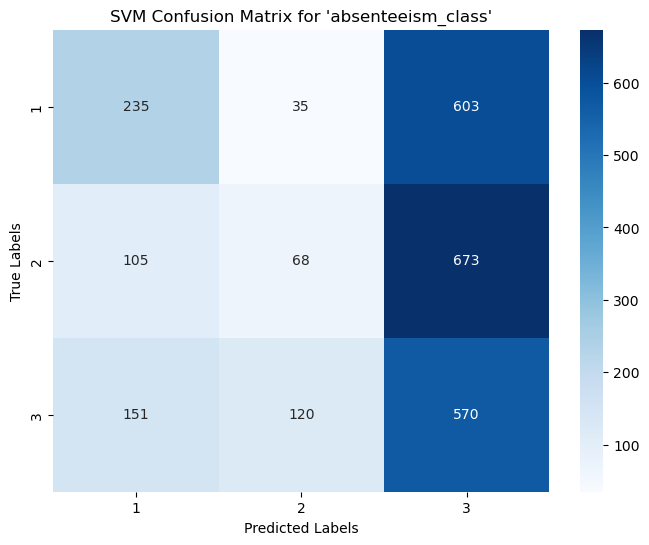


Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.27      0.34       873
           2       0.30      0.08      0.13       846
           3       0.31      0.68      0.42       841

    accuracy                           0.34      2560
   macro avg       0.36      0.34      0.30      2560
weighted avg       0.37      0.34      0.30      2560

AUC: 0.5115


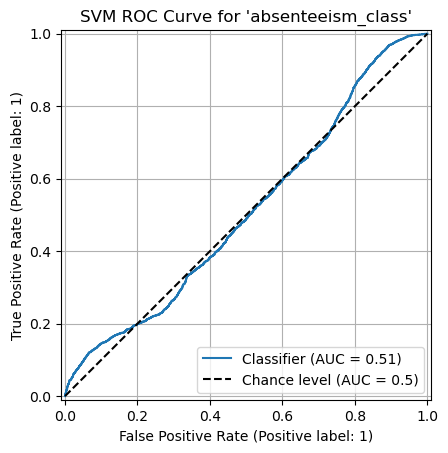

In [10]:
# Model with self absenteeism threshold; using rbf kernel
SVMModel(df5, "absenteeism_class", kernel="rbf");

### Hyperparameter Tuning

After kernel experiments, we return to the DOE-defined binary target and tune the `C` parameter to explore its impact on model performance. 

Confusion Matrix:
[[1137  680]
 [ 268  475]]


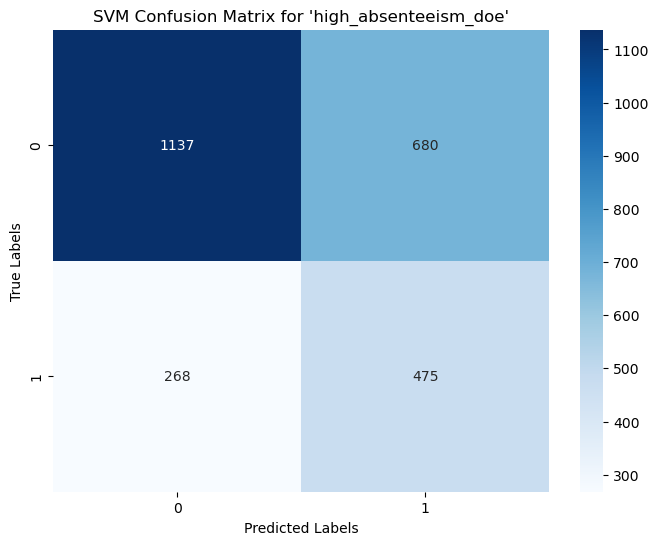


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.63      0.71      1817
           1       0.41      0.64      0.50       743

    accuracy                           0.63      2560
   macro avg       0.61      0.63      0.60      2560
weighted avg       0.69      0.63      0.65      2560

AUC: 0.6886


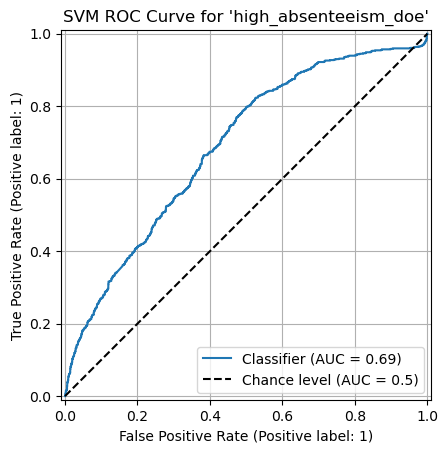

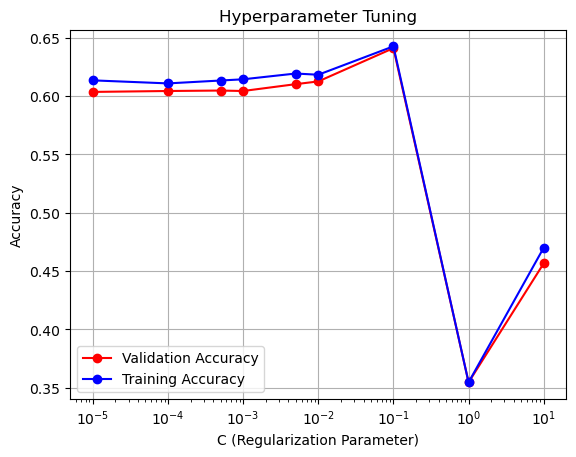

In [11]:
# Model with DOE-defined absenteeism threshold, tuning on C
SVMModel(df2, "high_absenteeism_doe", tune = True);

Confusion Matrix:
[[1276  541]
 [ 351  392]]


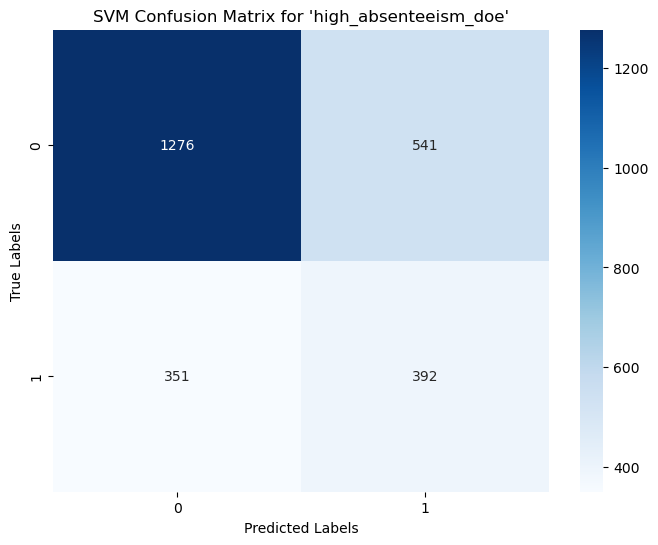


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1817
           1       0.42      0.53      0.47       743

    accuracy                           0.65      2560
   macro avg       0.60      0.61      0.60      2560
weighted avg       0.68      0.65      0.66      2560

AUC: 0.6642


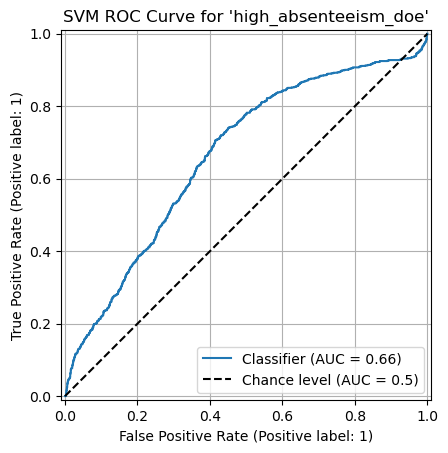

In [12]:
# Model with DOE-defined absenteeism threshold; using optimal C
SVMModel(df2, "high_absenteeism_doe", C = 0.1);

### Takeaways

The SVM model with a sigmoid kernel and $C=0.1$ achieved moderate performance in predicting high absenteeism as defined by the DOE. While overall accuracy was reasonable, the model struggled to correctly identify the minority class.

Although the model captures over half of high absenteeism cases, it generates many false positives and shows a clear bias toward the majority class. Improving recall and reducing false positives may require techniques like class balancing, cost-sensitive learning, or switching to ensemble models.

**Key takeaways:**
- Accuracy: 65%
- AUC: 0.664, indicating better than random classification
- SVM has limitations in capturing the likely complex relationships in the data, especially given the moderate AUC values and low accuracy

**Ideas for Improving the SVM Model in Future Work**
1. Handle Class Imbalance - Use techniques like SMOTE, class weights, or undersampling to help the model better detect high absenteeism cases.
2. Improve Features - Add or select more relevant features, such as trends over time or combining similar variables.
3. Include Time Patterns - Absenteeism likely varies by season or month, so using time-based features could help.